In [1]:
import warnings
warnings.simplefilter("ignore", UserWarning)
from tqdm.notebook import tqdm
import neurokit2 as nk
import numpy as np
import multiprocessing
import sys
import sklearn
sys.path.append('../')
import datasets, sqis, featurization


def get_features(subject_dict, sampling_rate=125, window_size=10):
    X_features_dict = {
        'features': [],
        'y_list': []
    }

    ## Calculate multi-lead features
    ## Remove baseline wader and dc offset with highpass Butterworth. Also remove powerline interference (50hz).        
    ecg_cleaned_list = [
        nk.ecg_clean(subject_dict[channel]['data'], sampling_rate=sampling_rate, method="neurokit")
        for channel in subject_dict.keys()
        ]

    i_sqi = sqis.i_sqi(ecg_cleaned_list, sampling_rate)
    pca_sqi = sqis.pca_sqi(np.array(ecg_cleaned_list).T) # 12 features

    ## Calculate single-lead features
    for i, channel in enumerate(subject_dict.keys()):
        ecg_raw = subject_dict[channel]['data']
        ecg_cleaned = ecg_cleaned_list[i]

        ## Find peaks indices
        peaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=sampling_rate, method='kalidas2017')[1]['ECG_R_Peaks']

        ## Featurize ecgs
        ecg_features = featurization.featurize_ecg(window=ecg_cleaned, sampling_rate=sampling_rate)
        ecg_sqis = sqis.get_ecg_sqis(ecg_raw, ecg_cleaned, peaks, sampling_rate, window=window_size) + [i_sqi, pca_sqi]

        X_features_dict['y_list'].append(subject_dict[channel]['label'])
        X_features_dict['features'].append(ecg_features + ecg_sqis)

    return X_features_dict

data_path='/zfsauton/project/public/chufang/PICC/'
output_dict = datasets.load_picc(data_path=data_path, verbose=False)

X_features_dict = {'features': [], 'y_list': [], 'subject': []}

with multiprocessing.Pool(processes=10) as pool:
    X_features_dicts = list(tqdm(pool.imap(get_features, [output_dict[subject] for subject in output_dict.keys()]), total=len(output_dict.keys())))
    for i, d in enumerate(X_features_dicts):
        for key in d.keys():
            X_features_dict[key].extend(d[key])
        
        X_features_dict['subject'].extend([i for _ in range(len(d['y_list']))])


998it [00:03, 256.66it/s]


  0%|          | 0/998 [00:00<?, ?it/s]

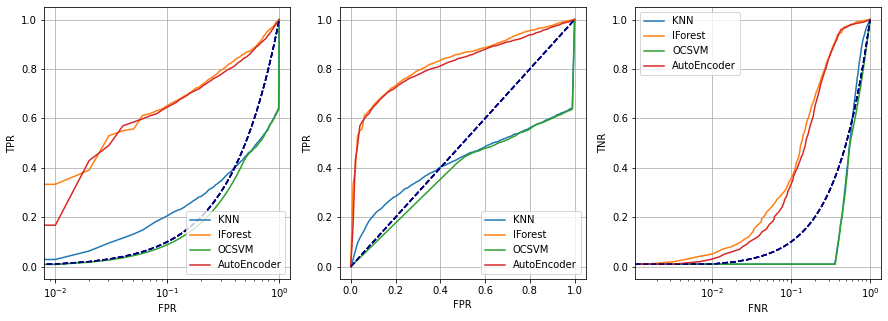

In [4]:
## Note that exact results cannot be reproduced as the official PICC challenge is trained on the entirety of set-a and evaluated on set-b
import sklearn.ensemble
from pyod.models.iforest import IForest
from pyod.models.ecod import ECOD
from pyod.models.knn import KNN
from pyod.models.pca import PCA
from pyod.models.ocsvm import OCSVM
from pyod.models.auto_encoder_torch import AutoEncoder
import matplotlib.pyplot as plt
import torch
import sys, os

subjects = np.array(X_features_dict['subject'])
gkf = sklearn.model_selection.GroupKFold(n_splits=5)

plt.figure(figsize=(15,5))

print('Method, Train AUC, Train Accuracy, Test AUC, Test Accuracy')
# for method in ['KNN', "IForest", "PCA", "OCSVM", "AutoEncoder"]:
for method in ['KNN', "IForest", "OCSVM", "AutoEncoder"]:
    mean_fpr = np.linspace(0, 1, 100)
    test_accs = []
    test_tprs = []
    test_aucs = []
    train_accs = []
    train_aucs = []

    for train_split, test_split in gkf.split(subjects, groups=subjects):
        # print("%s %s" % (subjects[train_split], subjects[test_split]))
        X_train_features_cleaned = np.nan_to_num(np.array(X_features_dict['features'])[train_split], nan=0.0, posinf=10000, neginf=-10000)
        X_test_features_cleaned = np.nan_to_num(np.array(X_features_dict['features'])[test_split], nan=0.0, posinf=10000, neginf=-10000)
        y_train = np.array(X_features_dict['y_list'])[train_split]
        y_test = np.array(X_features_dict['y_list'])[test_split]
    
        # model = sklearn.ensemble.RandomForestClassifier(random_state=0, n_estimators=1000, max_depth=5, n_jobs=10)
        # model.fit(X_train_features_cleaned, y_train)
        # scores = model.predict_proba(X_test_features_cleaned)[:,1]
        contamination = np.sum(y_train==1)/len(y_train)
        print(contamination)

        if method == 'IForest':
            model = IForest(n_estimators=1000, max_samples="auto", contamination=contamination, max_features=1.0, 
                bootstrap=False, n_jobs=10, behaviour='new', random_state=0)            
        elif method == 'KNN':
            model = KNN(contamination=contamination, n_neighbors=5, method='median', radius=1.0, algorithm='auto', 
                leaf_size=30, metric='l1', p=2, metric_params=None, n_jobs=1)
        elif method == 'PCA':
            model = PCA(n_components=None, n_selected_components=None, contamination=contamination, copy=True, 
                whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None, 
                weighted=True, standardization=True)
        elif method == 'OCSVM':
            model =  OCSVM(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, nu=0.5, shrinking=True, 
                cache_size=200, verbose=False, max_iter=- 1, contamination=contamination)
        elif method == 'AutoEncoder':
            torch.manual_seed(0)
            np.random.seed(0)
            model = AutoEncoder(hidden_neurons=[32, 32], hidden_activation='relu', batch_norm=True, 
                learning_rate=0.001, epochs=100, batch_size=32, dropout_rate=0.2, weight_decay=1e-05, 
                preprocessing=True, loss_fn=None, contamination=contamination, device=None)
        
        sys.stdout = open(os.devnull, 'w') # Block print from autoencoder fitting
        model.fit(X_train_features_cleaned)
        sys.stdout = sys.__stdout__ # reenable print

        test_scores = model.decision_function(X_test_features_cleaned)
        train_scores = model.decision_function(X_train_features_cleaned)

        train_accs.append(sklearn.metrics.accuracy_score(y_true=y_train, y_pred=train_scores > model.threshold_))
        train_aucs.append(sklearn.metrics.roc_auc_score(y_true=y_train, y_score=train_scores))
        test_accs.append(sklearn.metrics.accuracy_score(y_true=y_test, y_pred=test_scores > model.threshold_))
        test_aucs.append(sklearn.metrics.roc_auc_score(y_true=y_test, y_score=test_scores))

        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, test_scores, pos_label=1)
        test_tprs.append(np.interp(mean_fpr, fpr, tpr))
        

    mean_tpr = np.mean(test_tprs, axis=0)
    std_tpr = np.std(test_tprs, axis=0)
    
    plt.subplot(1, 3, 1)
    plt.plot(mean_fpr, mean_tpr, label=method)
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.grid(); plt.legend(loc="lower right")
    plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color="navy", linestyle="--")
    plt.xscale('log'); 

    plt.subplot(1, 3, 2)
    plt.plot(mean_fpr, mean_tpr, label=method)
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.grid(); plt.legend(loc="lower right")
    plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color="navy", linestyle="--")

    plt.subplot(1, 3, 3)
    plt.plot(1-mean_tpr, 1-mean_fpr, label=method)
    plt.xlabel('FNR'); plt.ylabel('TNR'); plt.grid(); plt.legend(loc="upper left")
    plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color="navy", linestyle="--")
    plt.xscale('log')
    
#     plt.plot(mean_fpr, mean_tpr, label=method)
    # plt.fill_between(mean_fpr, mean_tpr-std_tpr, mean_tpr+std_tpr, alpha=.2)
    print("{}, {:0.3f} $\pm$ {:0.3f}, {:0.3f} $\pm$ {:0.3f} , {:0.3f} $\pm$ {:0.3f}, {:0.3f} $\pm$ {:0.3f}".format(\
        method, np.mean(test_aucs), np.std(test_aucs), np.mean(test_accs), np.std(test_accs), \
        np.mean(train_aucs), np.std(train_aucs), np.mean(train_accs), np.std(train_accs)))
plt.subplot(1, 3, 1); plt.grid();
plt.subplot(1, 3, 2); plt.grid();
plt.subplot(1, 3, 3); plt.grid();
plt.show()
# plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.0]); 
# plt.xscale('log')
# plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("Test ROC Curve")
# plt.legend(loc="lower right"); plt.grid()


In [3]:
import sklearn

fprs, tprs, thresholds = sklearn.metrics.roc_curve(y_test, test_scores, pos_label=1)
fnrs = 1-tprs
tnrs = 1-fprs

def get_rates(y_test, test_scores, thresholds):
    fprs_ = []
    tprs_ = []
    fnrs_ = []
    tnrs_ = []
    
    for thresh in thresholds:
        confusion_matrix = sklearn.metrics.confusion_matrix(y_test, test_scores>=thresh)
        print(confusion_matrix.shape)
        FP = confusion_matrix[0,1]  
        FN = confusion_matrix[1,0]
        TP = confusion_matrix[1,1]
        TN = confusion_matrix[0,0]
        # Sensitivity, hit rate, recall, or true positive rate
        tprs_.append(TP/(TP+FN))
        # Specificity or true negative rate
        tnrs_.append(TN/(TN+FP))  
        # Fall out or false positive rate
        fprs_.append(FP/(FP+TN))
        # False negative rate
        fnrs_.append(FN/(TP+FN))
        
    return np.array(fprs_), np.array(tprs_), np.array(fnrs_), np.array(tnrs_)
    
fprs2, tprs2, fnrs2, tnrs2 = get_rates(y_test, test_scores, thresholds)

print(fprs==fprs2)
print(tprs==tprs2)
print(fnrs==fnrs2)
print(tnrs==tnrs2)